<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP/blob/main/04%20Deep%20Learning/notebooks/04-CNN-0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Convolutional Neural Networks

En esta notebook implementamos un ejemplo sencillo de una red CNN para el dataset de Fashion MNIST.

<img align="center" width="50%" src="https://github.com/DCDPUAEM/DCDP/blob/main/04%20Deep%20Learning/img/Fashion-MNIST.jpg?raw=1"/>

* [Más información sobre el dataset](https://keras.io/api/datasets/fashion_mnist/)
* [Benchmarks](https://paperswithcode.com/sota/image-classification-on-fashion-mnist) en este dataset.

In [ ]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print(f"X_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

4422102/4422102 [==============================] - 0s 0us/step
X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


Hacemos reescalimiento para tener los valores de intensidad de los pixeles como valores $0\leq x_i \leq 1$:

In [ ]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

Al ser clasificación multiclase tenemos que codificar los valores de clases a vectores de etiqueta:

In [ ]:
from keras.utils import to_categorical

print(f"y_train shape (valores de clase):\n{y_train.shape}")
num_classes = 10
y_train = to_categorical(y_train,num_classes)
y_test = to_categorical(y_test,num_classes)
print(f"y_train shape (vectores de clase):\n{y_train.shape}")

y_train shape (valores de clase):
(60000,)
y_train shape (vectores de clase):
(60000, 10)


Hacemos el reshape para incluir la información sobre el número de canales:

In [ ]:
print(f"x_train shape (antes):\n{x_train.shape}")
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
print(f"x_train shape (después):\n{x_train.shape}")

x_train shape (antes):
(60000, 28, 28)
x_train shape (después):
(60000, 28, 28, 1)


In [ ]:
#@title Función para graficar las curvas de entrenamiento

import matplotlib.pyplot as plt

def graficar_curvas(history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(history.history['loss'],label='Training')
    axs[0].plot(history.history['val_loss'],label='Validation')
    axs[0].set_title('Loss')
    axs[0].legend()
    axs[1].plot(history.history['accuracy'],label='Training')
    axs[1].plot(history.history['val_accuracy'],label='Validation')
    axs[1].set_title('Accuracy')
    axs[1].legend()
    fig.show()

Definimos un primer modelo de CNN. Usaremos las capas `Conv2D` para las operaciones de convolución y `MaxPooling2D` para el pooling.

* https://keras.io/api/layers/convolution_layers/convolution2d/
* https://keras.io/api/layers/pooling_layers/max_pooling2d/

Podemos definir el modelo Sequential como usualmente lo hacemos:

In [ ]:
# from keras.models import Sequential
# from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

# model = Sequential()
# model.add(Conv2D(filters=16,kernel_size=3,activation='relu',
#                 padding="same", strides=1,
#                  input_shape=(x_train.shape[1], x_train.shape[2], 1)))
# model.add(MaxPooling2D((2, 2)))
# model.add(Flatten())
# model.add(Dense(50, activation='relu'))
# # model.add(Dropout(0.1))
# model.add(Dense(10, activation='softmax'))

# model.summary()

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

O podemos definirlo por medio de una función, que nos permite generar modelos diferentes de forma rápida. Además, de esta manera nos aseguramos de tener modelos *en blanco*, listos para ser entrenados.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

def build_model(num_filtros=16,num_neuronas_densas=[50], dropout=False,
                optimizador='adam'):
    model = Sequential()
    model.add(Conv2D(filters=num_filtros,kernel_size=3,activation='relu',
                        padding="same", strides=1,
                        input_shape=(x_train.shape[1], x_train.shape[2], 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    if num_neuronas_densas is not None:
        for k in num_neuronas_densas:
            model.add(Dense(k, activation='relu'))
            if dropout:
                model.add(Dropout(0.1))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=optimizador, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 50)                156850    
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
Total params: 157520 (615.31 KB)
Trainable params: 157520 (615.31 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(x_train, y_train, epochs=30, validation_split=0.2,callbacks=[early_stopping])

Epoch 1/30
1500/1500 [==============================] - 8s 4ms/step - loss: 0.4783 - accuracy: 0.8315 - val_loss: 0.3811 - val_accuracy: 0.8621
Epoch 2/30
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3321 - accuracy: 0.8822 - val_loss: 0.3180 - val_accuracy: 0.8842
Epoch 3/30
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2853 - accuracy: 0.8975 - val_loss: 0.3086 - val_accuracy: 0.8887
Epoch 4/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2531 - accuracy: 0.9091 - val_loss: 0.2931 - val_accuracy: 0.8952
Epoch 5/30
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2295 - accuracy: 0.9159 - val_loss: 0.2666 - val_accuracy: 0.9058
Epoch 6/30
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2076 - accuracy: 0.9241 - val_loss: 0.2530 - val_accuracy: 0.9095
Epoch 7/30
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1926 - accuracy: 0.9286 - val_loss: 0.2569 - val_accuracy:

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.2861 - accuracy: 0.9035


[0.2861118018627167, 0.9035000205039978]

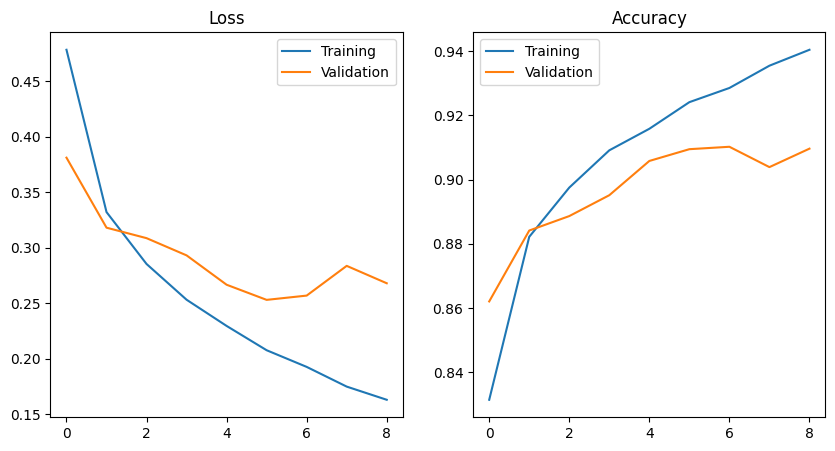

In [ ]:
graficar_curvas(history)

Recordemos el rendimiento de los algoritmos de Machine Learning clásico:

<img align="center" width="40%" src="https://github.com/DCDPUAEM/DCDP/blob/main/04%20Deep%20Learning/img/ML-Fashion-Mnist.png?raw=1"/>

Podemos entrenar nuevos modelos de forma muy rápida usando la función para generar los modelos:

In [ ]:
from keras.optimizers import Adadelta

#  Efecto de un optimizador en el entrenamiento y rendimiento

# Optimizador lento/malo para este ejemplo:
opt = Adadelta(learning_rate=0.0005)

In [ ]:
model = build_model(num_filtros=4,num_neuronas_densas=None,optimizador='SGD')
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=2)
history = model.fit(x_train, y_train, epochs=30, validation_split=0.2,callbacks=[early_stopping])
print("Evaluación en el conjunto de prueba:")
model.evaluate(x_test, y_test)[1]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 4)         40        
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 4)         0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7890 (30.82 KB)
Trainable params: 7890 (30.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
1500/1500 [==============================] - 6s 3ms/step - loss: 0.7672 - a

0.8495000004768372

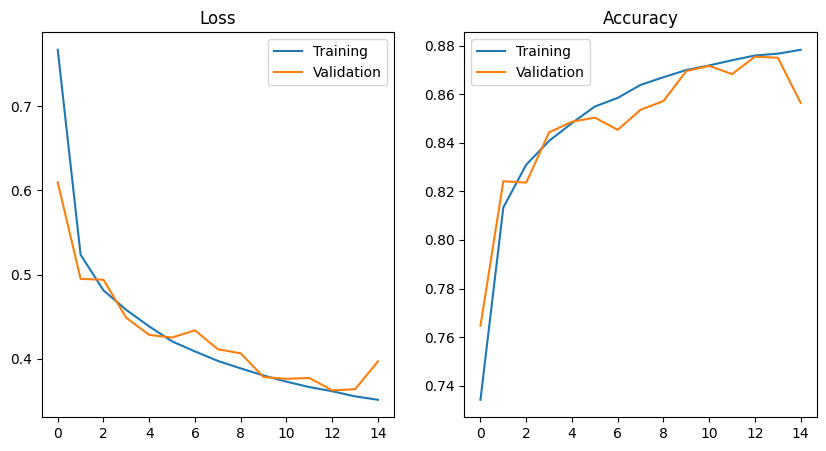

In [ ]:
graficar_curvas(history)

Probemos estas combinaciones:

* 16 | 50 | 10
* 8 | 50 con y sin dropout | 10
* 32 | 100 10 | 10
* 64 | 100 100 | 10
* 16 | - | 10

⭕ Práctica

Usando el mismo dataset, implementa las siguientes redes CNN usando como punto de partida la red que hemos implementado, ya sea la versión como función o la *normal* (si te sientes insegura/o respecto a la implementación, no uses el enfoque de función):

* Una red CNN con dos capas convolucionales, en lugar de uno. La segunda capa tendrá las siguientes especificaciones:
 * Una capa convolucional 2D de 8 filtros, el resto de hiperparámetros serán los mismos.
 * Una capa de MaxPooling.
* La red CNN anterior, con las mismas dos capas convolucionales. Cambia la función de activación por `tanh`. ¿Cómo cambian los resultados?
* La red CNN anterior, con las mismas dos capas convolucionales. Cambia el hiperparámetro `padding='valid'`. ¿Qué observas?
* La red CNN anterior, con las mismas dos capas convolucionales. En la parte MLP de la red, agrega 3 capas densas. Usa el número de neuronas en estas capas de tu elección, así como la función de activación en ellas. Experimenta un poco.
* Una red CNN con una capa convolucional con 32 filtros, la parte MLP tendrá un capa oculta de 100 neuronas con activación `relu`. Para el optimizador una un [`SGD`](https://keras.io/api/optimizers/sgd/) con tasa de aprendizaje $0.01$.


* Implementa una red MLP para este mismo problema. Prueba al menos 3 arquitecturas diferentes, ¿cuál fue la mejor opción? ¿cómo se compara con una CNN?
 * No olvides el conjunto de validación.
 * Usa el callback de `EarlyStopping`.
 * Cuida no re-entrenar modelos.

Para este último punto, usa el siguiente código para preparar el dataset:

In [ ]:
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print("Shapes al cargar el dataset:")
print(f"X train shape: {X_train.shape}")
print(f"y train shape: {y_train.shape}")
print(f"X test shape: {X_test.shape}")
print(f"y test shape: {y_test.shape}")

num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

print("\nShapes al preprocesar el dataset:")
print(f"X train shape: {X_train.shape}")
print(f"y train shape: {y_train.shape}")
print(f"X test shape: {X_test.shape}")
print(f"y test shape: {y_test.shape}")

Shapes al cargar el dataset:
X train shape: (60000, 28, 28)
y train shape: (60000,)
X test shape: (10000, 28, 28)
y test shape: (10000,)

Shapes al preprocesar el dataset:
X train shape: (60000, 784)
y train shape: (60000, 10)
X test shape: (10000, 784)
y test shape: (10000, 10)


#### Respuesta 1

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

def build_model(num_filtros=16,num_neuronas_densas=[50], dropout=False,
                optimizador='adam', activation='relu', pading='same'):
    model = Sequential()
    model.add(Conv2D(filters=num_filtros,kernel_size=3,activation=activation,
                        padding=pading, strides=1,
                        input_shape=(x_train.shape[1], x_train.shape[2], 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(filters=8,kernel_size=3,activation=activation,
                        padding=pading, strides=1,
                        input_shape=(x_train.shape[1], x_train.shape[2], 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    if num_neuronas_densas is not None:
        for k in num_neuronas_densas:
            model.add(Dense(k, activation=activation))
            if dropout:
                model.add(Dropout(0.1))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=optimizador, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 392)               0         
                                                                 
 dense_5 (Dense)             (None, 50)               

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(x_train, y_train, epochs=30, validation_split=0.2,callbacks=[early_stopping])

Epoch 1/30
1500/1500 [==============================] - 9s 5ms/step - loss: 0.5451 - accuracy: 0.8038 - val_loss: 0.4034 - val_accuracy: 0.8563
Epoch 2/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3809 - accuracy: 0.8640 - val_loss: 0.3579 - val_accuracy: 0.8709
Epoch 3/30
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3408 - accuracy: 0.8764 - val_loss: 0.3379 - val_accuracy: 0.8783
Epoch 4/30
1500/1500 [==============================] - 7s 4ms/step - loss: 0.3100 - accuracy: 0.8871 - val_loss: 0.3252 - val_accuracy: 0.8840
Epoch 5/30
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2868 - accuracy: 0.8948 - val_loss: 0.2890 - val_accuracy: 0.8956
Epoch 6/30
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2682 - accuracy: 0.9015 - val_loss: 0.3045 - val_accuracy: 0.8857
Epoch 7/30
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2557 - accuracy: 0.9065 - val_loss: 0.2718 - val_accuracy:

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.2858 - accuracy: 0.8981


[0.28581711649894714, 0.8981000185012817]

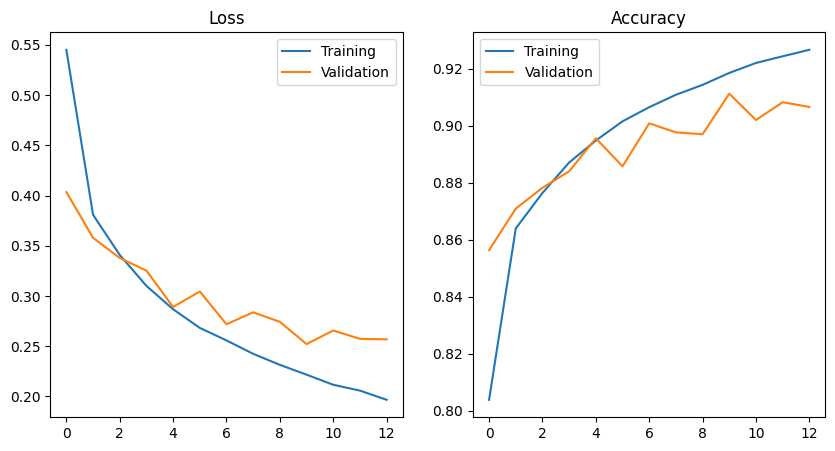

In [ ]:
graficar_curvas(history)

#### Respuesta 2

In [ ]:
model = build_model(activation='tanh')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 392)               0         
                                                                 
 dense_7 (Dense)             (None, 50)               

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(x_train, y_train, epochs=30, validation_split=0.2,callbacks=[early_stopping])

Epoch 1/30
1500/1500 [==============================] - 8s 4ms/step - loss: 0.5163 - accuracy: 0.8148 - val_loss: 0.4003 - val_accuracy: 0.8597
Epoch 2/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3471 - accuracy: 0.8754 - val_loss: 0.3405 - val_accuracy: 0.8779
Epoch 3/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3037 - accuracy: 0.8890 - val_loss: 0.3203 - val_accuracy: 0.8802
Epoch 4/30
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2776 - accuracy: 0.8979 - val_loss: 0.2824 - val_accuracy: 0.8974
Epoch 5/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2581 - accuracy: 0.9051 - val_loss: 0.2788 - val_accuracy: 0.8966
Epoch 6/30
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2393 - accuracy: 0.9126 - val_loss: 0.2763 - val_accuracy: 0.8994
Epoch 7/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2276 - accuracy: 0.9163 - val_loss: 0.2680 - val_accuracy:

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.2779 - accuracy: 0.9011


[0.27792683243751526, 0.9010999798774719]

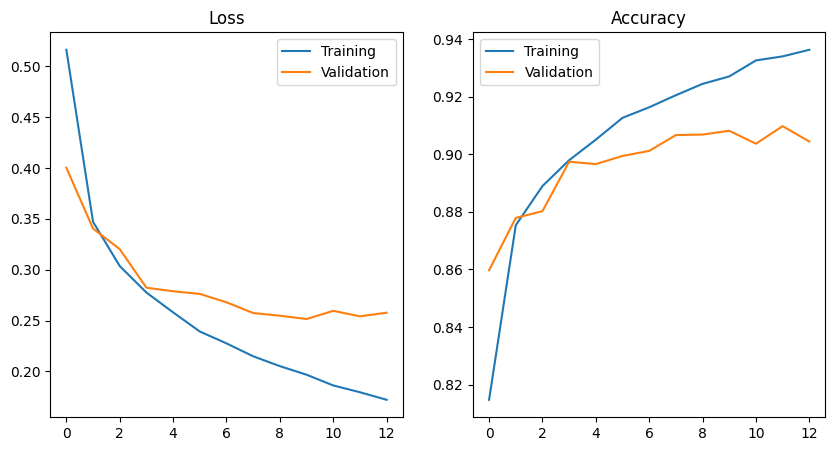

In [ ]:
graficar_curvas(history)

Que observas?
La curva de validacion en el grafico de loss y accuracy tiende a estabilizarse alrededor de la epoca 6

#### Respuesta 3

In [ ]:
model = build_model(activation='tanh', pading='valid')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 13, 13, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 11, 11, 8)         1160      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 5, 5, 8)           0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 200)               0         
                                                                 
 dense_9 (Dense)             (None, 50)               

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(x_train, y_train, epochs=30, validation_split=0.2,callbacks=[early_stopping])

Epoch 1/30
1500/1500 [==============================] - 8s 4ms/step - loss: 0.5636 - accuracy: 0.7977 - val_loss: 0.4386 - val_accuracy: 0.8373
Epoch 2/30
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3977 - accuracy: 0.8549 - val_loss: 0.3865 - val_accuracy: 0.8594
Epoch 3/30
1500/1500 [==============================] - 7s 4ms/step - loss: 0.3564 - accuracy: 0.8700 - val_loss: 0.3612 - val_accuracy: 0.8677
Epoch 4/30
1500/1500 [==============================] - 7s 4ms/step - loss: 0.3302 - accuracy: 0.8797 - val_loss: 0.3746 - val_accuracy: 0.8612
Epoch 5/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3127 - accuracy: 0.8859 - val_loss: 0.3252 - val_accuracy: 0.8792
Epoch 6/30
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2966 - accuracy: 0.8897 - val_loss: 0.3241 - val_accuracy: 0.8814
Epoch 7/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2845 - accuracy: 0.8948 - val_loss: 0.3072 - val_accuracy:

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.3192 - accuracy: 0.8894


[0.3192387819290161, 0.8894000053405762]

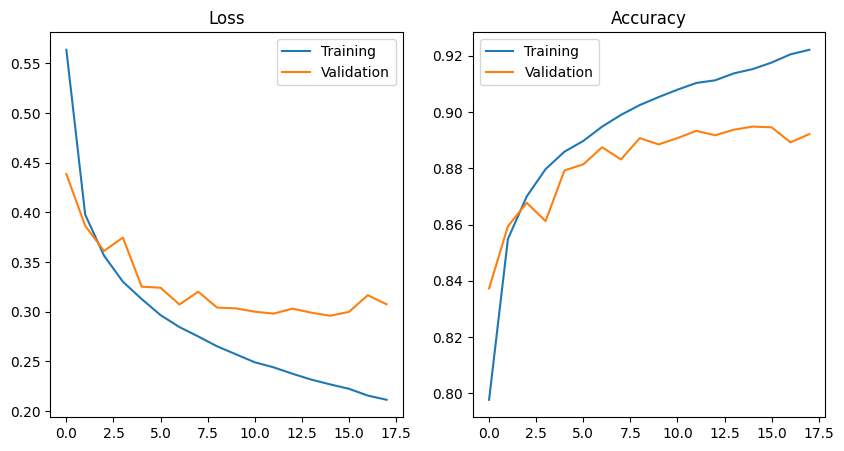

In [ ]:
graficar_curvas(history)

Que observas? Baja ligeramente la accuracy y sube ligeramente el loss para la validacion, aunque los valores tienden a estabilizarse alrededor de la epoca 10



#### Respuesta 4

In [ ]:
model = build_model(activation='tanh', pading='valid', num_neuronas_densas=[64, 64, 64])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 13, 13, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 11, 11, 8)         1160      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 5, 5, 8)           0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 200)               0         
                                                                 
 dense_11 (Dense)            (None, 64)               

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(x_train, y_train, epochs=30, validation_split=0.2,callbacks=[early_stopping])

Epoch 1/30
1500/1500 [==============================] - 8s 4ms/step - loss: 0.5480 - accuracy: 0.7972 - val_loss: 0.4348 - val_accuracy: 0.8377
Epoch 2/30
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3868 - accuracy: 0.8588 - val_loss: 0.3595 - val_accuracy: 0.8668
Epoch 3/30
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3455 - accuracy: 0.8729 - val_loss: 0.3397 - val_accuracy: 0.8752
Epoch 4/30
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3166 - accuracy: 0.8821 - val_loss: 0.3157 - val_accuracy: 0.8824
Epoch 5/30
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2957 - accuracy: 0.8894 - val_loss: 0.3125 - val_accuracy: 0.8838
Epoch 6/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2774 - accuracy: 0.8964 - val_loss: 0.3045 - val_accuracy: 0.8883
Epoch 7/30
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2637 - accuracy: 0.9028 - val_loss: 0.2992 - val_accuracy:

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.3142 - accuracy: 0.8869


[0.31415361166000366, 0.886900007724762]

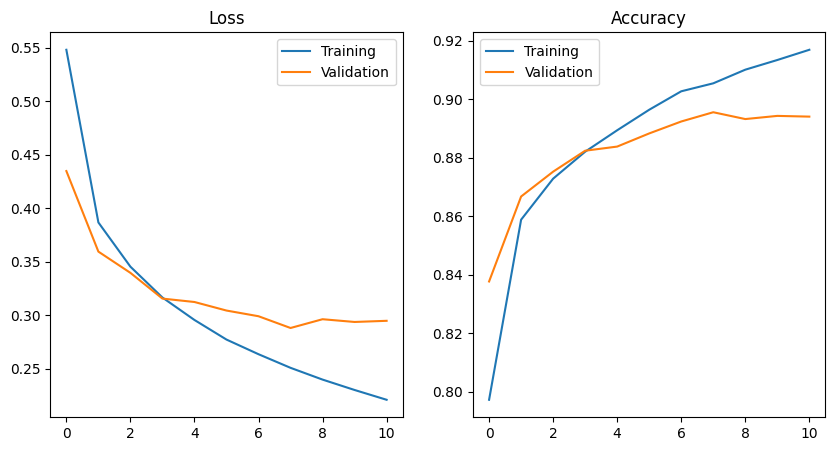

In [ ]:
graficar_curvas(history)

#### Respuesta 5

In [ ]:
import tensorflow as tf
optimizer = tf.keras.optimizers.SGD(0.01)
model = build_model(activation='relu', pading='valid', num_neuronas_densas=[100], num_filtros=32, optimizador=optimizer)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 8)         2312      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 5, 5, 8)           0         
 ng2D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 200)               0         
                                                                 
 dense_15 (Dense)            (None, 100)              

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(x_train, y_train, epochs=30, validation_split=0.2,callbacks=[early_stopping])

Epoch 1/30
1500/1500 [==============================] - 8s 4ms/step - loss: 0.9458 - accuracy: 0.6608 - val_loss: 0.6341 - val_accuracy: 0.7631
Epoch 2/30
1500/1500 [==============================] - 7s 4ms/step - loss: 0.5981 - accuracy: 0.7776 - val_loss: 0.5492 - val_accuracy: 0.7925
Epoch 3/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.5292 - accuracy: 0.8039 - val_loss: 0.5266 - val_accuracy: 0.8082
Epoch 4/30
1500/1500 [==============================] - 7s 5ms/step - loss: 0.4899 - accuracy: 0.8186 - val_loss: 0.4778 - val_accuracy: 0.8269
Epoch 5/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.4580 - accuracy: 0.8319 - val_loss: 0.4398 - val_accuracy: 0.8438
Epoch 6/30
1500/1500 [==============================] - 7s 4ms/step - loss: 0.4338 - accuracy: 0.8405 - val_loss: 0.4570 - val_accuracy: 0.8351
Epoch 7/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.4150 - accuracy: 0.8477 - val_loss: 0.4183 - val_accuracy:

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3343 - accuracy: 0.8808


[0.3342728614807129, 0.8808000087738037]

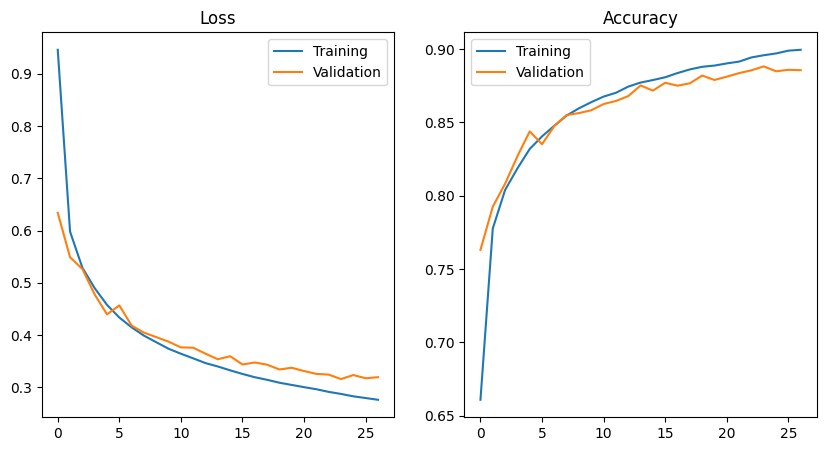

In [ ]:
graficar_curvas(history)

#### Respuesta 6

In [ ]:
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print("Shapes al cargar el dataset:")
print(f"X train shape: {X_train.shape}")
print(f"y train shape: {y_train.shape}")
print(f"X test shape: {X_test.shape}")
print(f"y test shape: {y_test.shape}")

num_classes = 10
y_test_original = y_test.copy()
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

print("\nShapes al preprocesar el dataset:")
print(f"X train shape: {X_train.shape}")
print(f"y train shape: {y_train.shape}")
print(f"X test shape: {X_test.shape}")
print(f"y test shape: {y_test.shape}")

Shapes al cargar el dataset:
X train shape: (60000, 28, 28)
y train shape: (60000,)
X test shape: (10000, 28, 28)
y test shape: (10000,)

Shapes al preprocesar el dataset:
X train shape: (60000, 784)
y train shape: (60000, 10)
X test shape: (10000, 784)
y test shape: (10000, 10)


##### Modelo 1

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

model = Sequential()
model.add(Flatten(input_shape=[X_train.shape[1]])) # Tenemos que aplanar las matrices representando a cada imagen, las capas densas sólo funcionan con vectores de entrada
model.add(Dense(8, activation='tanh'))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 dense_19 (Dense)            (None, 8)                 6280      
                                                                 
 dense_20 (Dense)            (None, 10)                90        
                                                                 
Total params: 6370 (24.88 KB)
Trainable params: 6370 (24.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy',
	      optimizer='adam',
	      metrics=['acc']
		  )

In [ ]:
n_epocas = 30

history = model.fit(X_train, y_train, epochs=n_epocas, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.8204 - acc: 0.7625 - val_loss: 0.5514 - val_acc: 0.8192
Epoch 2/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.5051 - acc: 0.8291 - val_loss: 0.4759 - val_acc: 0.8333
Epoch 3/30
1500/1500 [==============================] - 9s 6ms/step - loss: 0.4537 - acc: 0.8415 - val_loss: 0.4441 - val_acc: 0.8462
Epoch 4/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4291 - acc: 0.8494 - val_loss: 0.4454 - val_acc: 0.8434
Epoch 5/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4160 - acc: 0.8530 - val_loss: 0.4302 - val_acc: 0.8481
Epoch 6/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4090 - acc: 0.8556 - val_loss: 0.4272 - val_acc: 0.8493
Epoch 7/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4016 - acc: 0.8584 - val_loss: 0.4303 - val_acc: 0.8524
Epoch 8/30
1500/1500 [==============================] - 5s 4ms

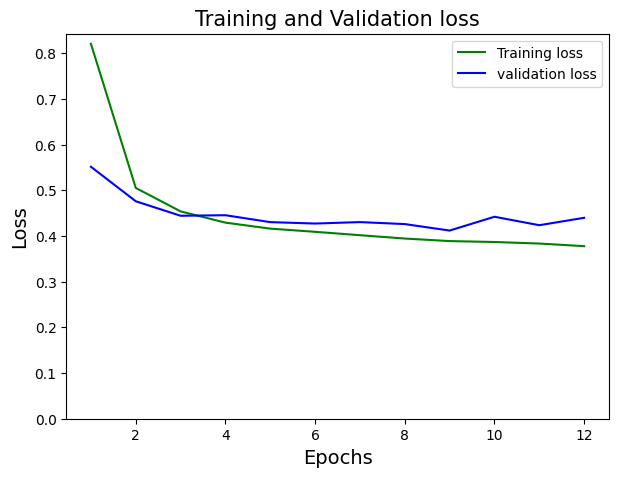

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

epochs = range(1,len(history.epoch)+1)

plt.figure(figsize=(7,5))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss',fontsize=15)
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.ylim(0, None)
plt.legend()
plt.show()

##### Modelo 2

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

model = Sequential()
model.add(Flatten(input_shape=[X_train.shape[1]])) # Tenemos que aplanar las matrices representando a cada imagen, las capas densas sólo funcionan con vectores de entrada
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',
	      optimizer='adam',
	      metrics=['acc']
		  )

In [ ]:
n_epocas = 30

history = model.fit(X_train, y_train, epochs=n_epocas, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/30
1500/1500 [==============================] - 6s 3ms/step - loss: 0.5532 - acc: 0.8084 - val_loss: 0.4476 - val_acc: 0.8432
Epoch 2/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4135 - acc: 0.8535 - val_loss: 0.3885 - val_acc: 0.8676
Epoch 3/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3739 - acc: 0.8684 - val_loss: 0.3932 - val_acc: 0.8577
Epoch 4/30
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3484 - acc: 0.8742 - val_loss: 0.3701 - val_acc: 0.8687
Epoch 5/30
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3321 - acc: 0.8794 - val_loss: 0.3588 - val_acc: 0.8765
Epoch 6/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3174 - acc: 0.8846 - val_loss: 0.3472 - val_acc: 0.8780
Epoch 7/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3064 - acc: 0.8885 - val_loss: 0.3422 - val_acc: 0.8774
Epoch 8/30
1500/1500 [==============================] - 5s 4ms

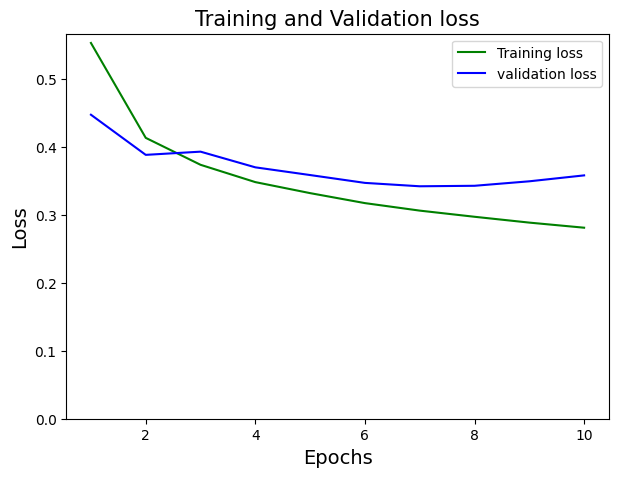

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

epochs = range(1,len(history.epoch)+1)

plt.figure(figsize=(7,5))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss',fontsize=15)
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.ylim(0, None)
plt.legend()
plt.show()

In [ ]:
import numpy as np
predictions_matrix = model.predict(X_test)
predictions = np.argmax(predictions_matrix, axis=1)  # Prueba a comentar esta línea y discutamos qué pasa

313/313 [==============================] - 1s 2ms/step


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
print(f"Test Accuracy: {accuracy_score(y_pred=predictions,y_true=y_test_original)}")
print(f"Test Recall: {recall_score(y_pred=predictions,y_true=y_test_original,average='macro')}")
print(f"Test Precision: {precision_score(y_pred=predictions,y_true=y_test_original,average='macro')}")

Test Accuracy: 0.861
Test Recall: 0.861
Test Precision: 0.8621868072204819


la accuracy es ligeramente inferior a CNN

Dudas: mauricio.toledo@unison.mx

Respecto a las dimensiones de salida de una capa convolucional: [wikipedia](https://en.wikipedia.org/wiki/Convolutional_neural_network#Convolutional_layer), [stackoverflow](https://stackoverflow.com/questions/53580088/calculate-the-output-size-in-convolution-layer).